In [1]:
%pylab inline
import datetime
import pytz
from pyiem.util import get_dbconn
ASOS = get_dbconn('asos')
acursor = ASOS.cursor()

acursor.execute("""
 SELECT extract(year from valid) as yr, min(valid) from alldata 
 WHERE station = 'AMW' and tmpf < 31.5 and extract(month from valid) > 7
 GROUP by yr ORDER by yr ASC
""")
events = []
for row in acursor:
    events.append( row[1] )
events.append(datetime.datetime(2017, 10, 16, 10).replace(tzinfo=pytz.utc))
print("Found %s events" % (len(events), ))

Populating the interactive namespace from numpy and matplotlib
Found 22 events


In [2]:
ASOS = get_dbconn('asos')
acursor = ASOS.cursor()
times = []
wcht = []
labels = []
for event in events:
    acursor.execute("""
    SELECT valid, tmpf from alldata WHERE station = 'AMW'
    and tmpf > -50 and valid BETWEEN '%s'::timestamptz - '3 days'::interval
    and '%s'::timestamptz + '1 days'::interval
    ORDER by valid ASC
    """ % (event, event))
    t =[]
    v =[]
    for row in acursor:
        t.append( row[1] )
        v.append( row[0] )
    labels.append( event )
    times.append( v )
    wcht.append( t )

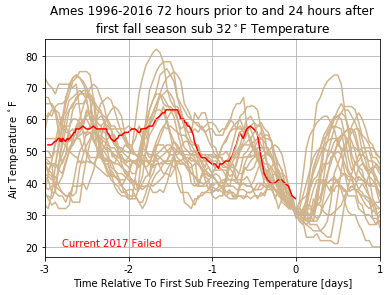

In [3]:
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots(1,1)

for i,(v,t) in enumerate(zip(times, wcht)):
    v2 = []
    for myv in v:
        v2.append( (myv - labels[i]).days * 86400. + (myv - labels[i]).seconds)
    color = 'tan' if labels[i].year != 2017 else 'red'
    if labels[i].year == 1983:
        color = 'blue'
    zorder = 2 if labels[i].year in [2014,1983] else 1
    ax.plot(v2, t, zorder=zorder, color=color, lw=1.5, label="%s %.1f$^\circ$F" % (labels[i].strftime("%d %b %Y"), min(t)))

ax.grid(True)
ax.set_ylabel("Air Temperature $^\circ$F")
ax.set_title("Ames 1996-2016 72 hours prior to and 24 hours after\nfirst fall season sub 32$^\circ$F Temperature")
ax.set_xlabel("Time Relative To First Sub Freezing Temperature [days]")
#ax.legend(loc=(1.01,0), fontsize=10, ncol=2)
ax.set_xticks(range(-86400*6,86400*1+1,86400))
ax.set_xticklabels(range(-6,7,1))
ax.text(0.05, 0.05, "Current 2017 Failed", transform=ax.transAxes, color='r')
ax.set_xlim(-3*86400,1*86400)
fig.savefig('test.png', dpi=150)